In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

In [3]:
# helper functions

def featureProportion(path, frac_features, frac_features_names, drop_features):
#     drop_features: list of strings with the names of the categorical features 
#     binary_features: list of string witht the names of the binary columns
#     target_col: string

    df = pd.read_csv(path, low_memory = False)
    df = df.dropna()
    
    total_courses_count = "cnt_courses_in_specialization"
    
    for feature, name in zip(frac_features, frac_features_names):
        
        df[name] = df[feature] / df[total_courses_count]

    df = df.drop(columns = drop_features)
    
    return df

In [4]:

data_descriptions = pd.read_csv('data_descriptions.csv')
pd.set_option('display.max_colwidth', None)
data_descriptions

,Column_name,Column_type,Data_type,Description
0,subscription_id,Identifier,character,Unique identifier of each subscription
1,observation_dt,Identifier,date,The date on which the subscription was observed to calculate the features in the dataset. It was chosen at random amongst all the dates between the start of the subscription and the end of the subscription (before cancellation)
2,is_retained,Target,Integer,"TRAINING SET ONLY! 0 = the learner cancelled their subscription before next payment, 1 = the learner made an additional payment in this subscription"
3,specialization_id,Feature - Specialization Info,character,Unique identifier of a specialization (each subscription gives a learner access to a particular specialization)
4,cnt_courses_in_specialization,Feature - Specialization Info,integer,number of courses in the specialization
5,specialization_domain,Feature - Specialization Info,character,"primary domain of the specialization (Computer Science, Data Science, etc.)"
6,is_professional_certificate,Feature - Specialization Info,boolean,"BOOLEAN for whether the specialization is a ""professional certicate"" (a special type of specialization that awards completers with an industry-sponsored credential)"
7,is_gateway_certificate,Feature - Specialization Info,boolean,"BOOLEAN for whether the specialization is a ""gateway certificate"" (a special type of specialization geared towards learners starting in a new field)"
8,learner_days_since_registration,Feature - Learner Info,integer,Days from coursera registration date to the date on which the observation is made
9,learner_country_group,Feature - Learner Info,character,"the region of the world that the learner is from (United States, East Asia, etc.)"


#### load the data

In [5]:
dataset = pd.read_csv("dataset.csv", low_memory = False)

dataset.shape

(413955, 37)

In [6]:
dataset.head()

,subscription_id,observation_dt,is_retained,specialization_id,cnt_courses_in_specialization,specialization_domain,is_professional_certificate,is_gateway_certificate,learner_days_since_registration,learner_country_group,...,cnt_enrollments_completed_during_payment_period,cnt_enrollments_active_during_payment_period,cnt_items_completed_during_payment_period,cnt_graded_items_completed_during_payment_period,is_active_capstone_during_pay_period,sum_hours_learning_before_payment_period,sum_hours_learning_during_payment_period,cnt_days_active_before_payment_period,cnt_days_active_during_payment_period,cnt_days_since_last_activity
0,--rKikbGEeyQHQqIvaM5IQ,2022-05-04,1.0,kr43OcbTEeqeNBKhfgCLyw,8.0,Data Science,True,True,2321.0,Northern Europe,...,0.0,0.0,0.0,0.0,False,73.783333,0.000000,68.0,0.0,20.0
1,-0XGzEq2EeyimBISGRuNeQ,2021-11-30,0.0,Q0Fc_Yl0EeqdTApgQ4tM7Q,6.0,Data Science,True,False,612.0,Northern Europe,...,0.0,0.0,0.0,0.0,False,0.850000,0.000000,7.0,2.0,0.0
2,-1P9kOb6EeuRugq1Liq62w,2021-08-13,0.0,9kmimrDIEeqxzQqieMm42w,6.0,Business,True,True,27.0,Australia and New Zealand,...,0.0,1.0,12.0,2.0,False,1.833333,2.983333,2.0,1.0,18.0
3,-2ifTJZbEeuIuRKpAhovaw,2021-08-03,1.0,7lHCSlFIEeeffRIHljDI_g,5.0,Information Technology,True,True,120.0,United States,...,0.0,2.0,83.0,9.0,False,18.450000,7.100000,18.0,4.0,3.0
4,-5YKZbchEeufeAq6C_fAOw,2021-06-04,0.0,kr43OcbTEeqeNBKhfgCLyw,8.0,Data Science,True,True,1228.0,India,...,1.0,1.0,61.0,4.0,False,29.566667,15.250000,18.0,8.0,1.0


In [7]:
# convert integers of course enrollment to fractions
frac_features = ["cnt_enrollments_started_before_payment_period", 
                                    "cnt_enrollments_completed_before_payment_period", 
                                    "cnt_enrollments_active_before_payment_period", 
                                    "cnt_enrollments_started_during_payment_period", 
                                    "cnt_enrollments_completed_during_payment_period", 
                                    "cnt_enrollments_active_during_payment_period",]

frac_features_names = ["frc_enrollments_started_before_payment_period", 
                       "frc_enrollments_completed_before_payment_period", 
                       "frc_enrollments_active_before_payment_period", 
                       "frc_enrollments_started_during_payment_period", 
                       "frc_enrollments_completed_during_payment_period", 
                       "frc_enrollments_active_during_payment_period",]

# drop the categorical features
drop_features = ["cnt_enrollments_started_before_payment_period", 
                 "cnt_enrollments_completed_before_payment_period", 
                 "cnt_enrollments_active_before_payment_period", 
                 "cnt_enrollments_started_during_payment_period", 
                 "cnt_enrollments_completed_during_payment_period", 
                 "cnt_enrollments_active_during_payment_period",]

In [8]:
# preprocessing training set
path_data = "dataset.csv"
dataset = featureProportion(path_data, frac_features, frac_features_names, drop_features)

# time and event columns
time_col = "learner_days_since_registration"
event_col = "is_retained"

In [9]:
# from categorical to numerical features

dataset = dataset.drop(columns = "learner_gender")

categories = ["specialization_domain", "is_professional_certificate", "is_gateway_certificate", 
              "learner_country_group", "is_subscription_started_with_free_trial", 
              "is_active_capstone_during_pay_period"]



In [10]:
dataset.dtypes

subscription_id                                      object
observation_dt                                       object
is_retained                                         float64
specialization_id                                    object
cnt_courses_in_specialization                       float64
specialization_domain                                object
is_professional_certificate                          object
is_gateway_certificate                               object
learner_days_since_registration                     float64
learner_country_group                                object
learner_cnt_other_courses_active                    float64
learner_cnt_other_courses_paid_active               float64
learner_cnt_other_courses_items_completed           float64
learner_cnt_other_courses_paid_items_completed      float64
learner_cnt_other_transactions_past                 float64
learner_other_revenue                               float64
subscription_period_order               

In [11]:
# covert object features into categorical
for column in dataset.columns:

  if (dataset[column].dtype == "object"):

    dataset[column] = dataset[column].astype("category")

In [12]:
dataset.specialization_domain

0                   Data Science
1                   Data Science
2                       Business
3         Information Technology
4                   Data Science
                   ...          
413949              Data Science
413950                  Business
413951          Computer Science
413952                  Business
413953              Data Science
Name: specialization_domain, Length: 413953, dtype: category
Categories (11, object): ['Arts and Humanities', 'Business', 'Computer Science', 'Data Science', ..., 'Math and Logic', 'Personal Development', 'Physical Science and Engineering', 'Social Sciences']

In [13]:
N_null = sum(dataset.isnull().sum())
print("The coursera subscription dataset contains {} null values.".format(N_null))

The coursera subscription dataset contains 0 null values.


#### KM Survival curves

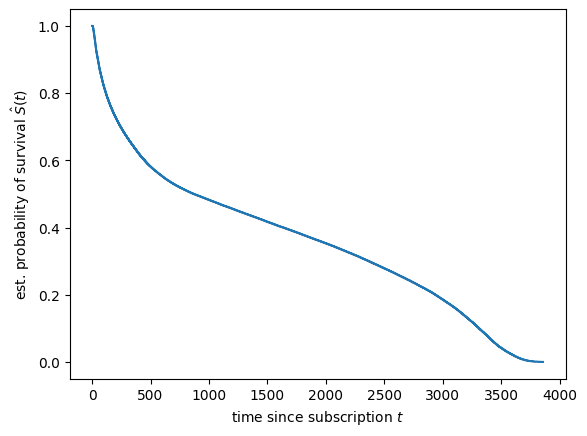

In [52]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    dataset[event_col].values.astype(bool), dataset[time_col].values, 
    conf_type="log-log")

plt.step(time, survival_prob)
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.1, color = "red")

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time since subscription $t$")

#plt.xlim(left = 3500, right = 3600)
#plt.ylim(top = 1, bottom = 0.9)
plt.show()

##### Survival curves for subscribers that started using free trial and paid subscriptions 

In [53]:
# filter out the subscriptions that started as a free trial and explore the survival curves for both groups

free_trial_dataset = dataset[dataset["is_subscription_started_with_free_trial"]]
paid_subs_dataset = dataset[dataset["is_subscription_started_with_free_trial"] == False]

free_time, free_survival_prob, free_conf_int = kaplan_meier_estimator(
    free_trial_dataset[event_col].values.astype(bool), free_trial_dataset[time_col].values, 
    conf_type="log-log")

paid_time, paid_survival_prob, paid_conf_int = kaplan_meier_estimator(
    paid_subs_dataset[event_col].values.astype(bool), paid_subs_dataset[time_col].values, 
    conf_type="log-log")

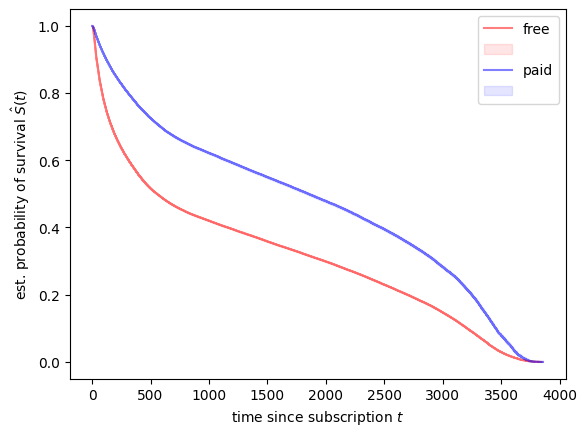

In [54]:
plt.step(free_time, free_survival_prob, color = "red", alpha = 0.5)
plt.fill_between(free_time, free_conf_int[0], free_conf_int[1], alpha=0.1, color = "red")

plt.step(paid_time, paid_survival_prob, color = "blue", alpha = 0.5)
plt.fill_between(paid_time, paid_conf_int[0], paid_conf_int[1], alpha=0.1, color = "blue")

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time since subscription $t$")

plt.legend(["free", "", "paid",""], loc = "best")

plt.show()

##### Different specialization domains

In [55]:
dataset.specialization_domain.unique()[:5]

['Data Science', 'Business', 'Information Technology', 'Computer Science', 'Arts and Humanities']
Categories (11, object): ['Arts and Humanities', 'Business', 'Computer Science', 'Data Science', ..., 'Math and Logic', 'Personal Development', 'Physical Science and Engineering', 'Social Sciences']

In [56]:
ds_dataset = dataset[dataset["specialization_domain"] == "Data Science"]
business_dataset = dataset[dataset["specialization_domain"] == "Business"]

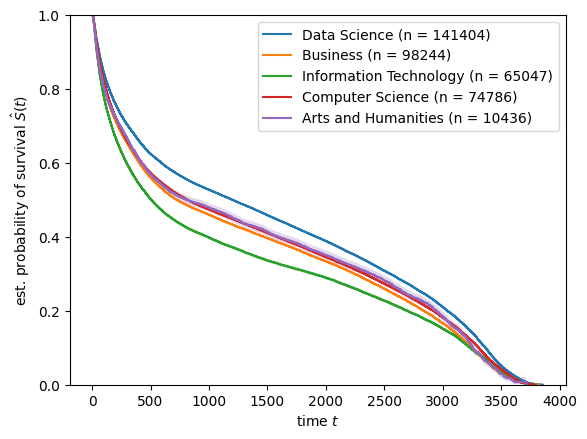

In [57]:
for specialization in dataset.specialization_domain.unique()[:5]:
    mask = dataset["specialization_domain"] == specialization
    
    time, survival_prob, conf_int = kaplan_meier_estimator(
    dataset[event_col][mask].values.astype(bool), dataset[time_col][mask].values, conf_type = "log-log")
    
    plt.step(time, survival_prob, where="post", label=f"{specialization} (n = {mask.sum()})")
    plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")


plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

plt.show()

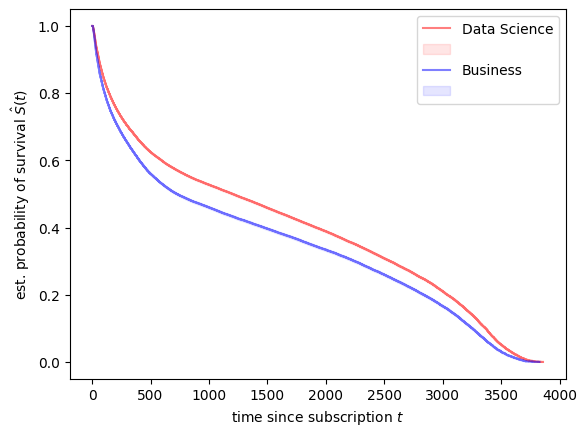

In [58]:
ds_time, ds_survival_prob, ds_conf_int = kaplan_meier_estimator(
    ds_dataset[event_col].values.astype(bool), ds_dataset[time_col].values, 
    conf_type="log-log")
business_time, business_survival_prob, business_conf_int = kaplan_meier_estimator(
    business_dataset[event_col].values.astype(bool), business_dataset[time_col].values, 
    conf_type="log-log")

plt.step(ds_time, ds_survival_prob, color = "red", alpha = 0.5)
plt.fill_between(ds_time, ds_conf_int[0], ds_conf_int[1], alpha=0.1, color = "red")

plt.step(business_time, business_survival_prob, color = "blue", alpha = 0.5)
plt.fill_between(business_time, business_conf_int[0], business_conf_int[1], alpha=0.1, color = "blue")

plt.legend(["Data Science", "", "Business", ""], loc = "best")

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time since subscription $t$")

plt.show()

#### Random Survival Forest

In [16]:
from sksurv.datasets import load_gbsg2

In [17]:
X, y = load_gbsg2()

In [21]:
y

array([( True, 1814.), ( True, 2018.), ( True,  712.), ( True, 1807.),
       ( True,  772.), ( True,  448.), (False, 2172.), (False, 2161.),
       ( True,  471.), (False, 2014.), ( True,  577.), ( True,  184.),
       (False, 1840.), (False, 1842.), (False, 1821.), ( True, 1371.),
       ( True,  707.), (False, 1743.), (False, 1781.), ( True,  865.),
       ( True, 1684.), (False, 1701.), (False, 1701.), (False, 1693.),
       ( True,  379.), ( True, 1105.), ( True,  548.), ( True, 1296.),
       (False, 1483.), (False, 1570.), (False, 1469.), (False, 1472.),
       (False, 1342.), (False, 1349.), ( True, 1162.), (False, 1342.),
       ( True,  797.), (False, 1232.), (False, 1230.), (False, 1205.),
       (False, 1090.), (False, 1095.), ( True,  449.), (False,  972.),
       (False,  825.), (False, 2438.), (False, 2233.), ( True,  286.),
       (False, 1861.), ( True, 1080.), ( True, 1521.), (False, 1693.),
       ( True, 1528.), ( True,  169.), ( True,  272.), ( True,  731.),
      

In [14]:
# one-hot (or ordinal) enconding categorical variables
for column in dataset.select_dtypes(include = ["category"]).columns:

    dataset[column] = dataset[column].astype("category").cat.codes

In [15]:
dataset.dtypes

subscription_id                                       int32
observation_dt                                        int16
is_retained                                         float64
specialization_id                                     int16
cnt_courses_in_specialization                       float64
specialization_domain                                  int8
is_professional_certificate                            int8
is_gateway_certificate                                 int8
learner_days_since_registration                     float64
learner_country_group                                  int8
learner_cnt_other_courses_active                    float64
learner_cnt_other_courses_paid_active               float64
learner_cnt_other_courses_items_completed           float64
learner_cnt_other_courses_paid_items_completed      float64
learner_cnt_other_transactions_past                 float64
learner_other_revenue                               float64
subscription_period_order               

In [124]:
# bool "is_retained" column as integer
# dataset.is_retained = dataset.is_retained.astype(bool)

In [16]:
# drop the id coluns
# drop time variable ("observation_dt")
# split the data into training, validation and test sets to determine how well the model generalizes

random_state = 1234

# set X_data and y_data before splitting
X_data = dataset.drop(columns = ["is_retained", "learner_days_since_registration", "subscription_id", 
                                 "observation_dt", "specialization_id"])

# y_data y must be a structured array with the first field being a binary class event indicator and the 
# second field the time of the event/censoring
# y_data = dataset["is_retained"].values
y_list = list(zip(dataset[event_col], dataset[time_col]))
y_data = np.array(y_list, dtype = [("label", bool), ("time", float)])


# split into training, validation and test sets
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.4, random_state = random_state)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, random_state = random_state)

In [17]:
y_train

array([(False,  491.), ( True,   37.), (False,  326.), ...,
       (False, 1315.), (False,  141.), ( True, 2778.)],
      dtype=[('label', '?'), ('time', '<f8')])

In [18]:
X_train

,cnt_courses_in_specialization,specialization_domain,is_professional_certificate,is_gateway_certificate,learner_country_group,learner_cnt_other_courses_active,learner_cnt_other_courses_paid_active,learner_cnt_other_courses_items_completed,learner_cnt_other_courses_paid_items_completed,learner_cnt_other_transactions_past,...,sum_hours_learning_during_payment_period,cnt_days_active_before_payment_period,cnt_days_active_during_payment_period,cnt_days_since_last_activity,frc_enrollments_started_before_payment_period,frc_enrollments_completed_before_payment_period,frc_enrollments_active_before_payment_period,frc_enrollments_started_during_payment_period,frc_enrollments_completed_during_payment_period,frc_enrollments_active_during_payment_period
193241,6.0,1,1,1,14,1.0,0.0,11.0,0.0,0.0,...,0.000000,4.0,0.0,96.0,0.166667,0.00,0.166667,0.00,0.0,0.000
296588,5.0,4,0,0,14,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.0,0.0,37.0,0.200000,0.00,0.200000,0.00,0.0,0.000
348138,4.0,1,0,0,2,1.0,0.0,1.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.00,0.000000,0.25,0.0,0.000
49278,5.0,3,0,0,14,1.0,0.0,18.0,0.0,0.0,...,6.333333,6.0,4.0,9.0,0.200000,0.00,0.200000,0.00,0.0,0.200
413712,5.0,3,0,0,14,11.0,6.0,268.0,196.0,6.0,...,0.000000,5.0,0.0,103.0,0.200000,0.00,0.200000,0.00,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294543,6.0,1,1,1,14,0.0,0.0,0.0,0.0,0.0,...,0.000000,8.0,0.0,55.0,0.166667,0.00,0.166667,0.00,0.0,0.000
344729,8.0,3,1,1,14,0.0,0.0,0.0,0.0,0.0,...,3.550000,31.0,3.0,5.0,0.625000,0.50,0.625000,0.00,0.0,0.125
220532,10.0,3,1,1,14,1.0,0.0,6.0,0.0,0.0,...,0.000000,16.0,0.0,188.0,0.300000,0.20,0.300000,0.00,0.0,0.000
384054,4.0,3,1,0,3,5.0,1.0,465.0,222.0,3.0,...,3.083333,4.0,1.0,0.0,0.500000,0.25,0.250000,0.00,0.0,0.250


In [19]:
# train rsf model
rsf = RandomSurvivalForest(
    n_estimators = 10, min_samples_split = 10, min_samples_leaf = 15, n_jobs = -1, random_state = random_state
)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, n_estimators=10,
                     n_jobs=-1, random_state=1234)

In [ ]:
rsf.score(X_val, y_val)